https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e
https://www.stat.auckland.ac.nz/~fewster/325/notes/ch8.pdf
https://rstudio-pubs-static.s3.amazonaws.com/136018_2d1e15ca17984bd79236b4964dfb93f9.html
https://python.quantecon.org/finite_markov.html
https://arxiv.org/pdf/2001.07824.pdf
http://old.math.ku.dk/noter/filer/stoknoter.pdf

In [121]:
from pymc3.gp.util import plot_gp_dist

In [122]:
def scaleX(x):
    return list(x/np.sum(x))

def rBeta(a,b):
    return np.random.beta(a,b)

def getStats(arr):
    upr = np.quantile(arr, 0.95)
    mu = np.quantile(arr, 0.5)
    lwr = np.quantile(arr, 0.05)
    return np.array([mu, lwr, upr])

def markovChain(state, M, N = 100, P0 = []):
    stateHist=state
    dfStateHist=pd.DataFrame(state)
    distr_hist = [[0,0,0]]
    burned_minted = np.array([0])
    green_minted = np.array([0]) 
    
    for x in range(N):
        P = genTransMatrix() if len(P0) == 0 else P0
       
        burned_minted = np.append(burned_minted, P[0,2]*state[0,0] + P[1,2]*state[0,1])
        green_minted = np.append(green_minted, P[1,0]*state[0,1] + P[2,0]*state[0,2])
                 
        #P = genTransMatrix() 
        P_scale = np.multiply(P,M)
        state = np.dot(state,P_scale)
        state = state + np.array([[0, 100000, 0.0]])
        stateHist=np.append(stateHist,state,axis=0)
        
    dfDistrHist = pd.DataFrame(stateHist)    
    dfDistrHist.columns = ['Green', 'NFT', 'Burned'] 
    dfDistrHist.insert(3, "Burned_Minted", burned_minted, True)
    dfDistrHist.insert(4, "Burned_Minted_Tot", np.cumsum(burned_minted), True)
    dfDistrHist.insert(5, "Green_Minted", green_minted, True)
    dfDistrHist.insert(6, "Green_Minted_Tot", np.cumsum(green_minted), True)
        
    return dfDistrHist   

def genTransMatrix():
    P = np.array([[rBeta(19,1), 0, rBeta(1,19)],
              [rBeta(1,19), rBeta(9,1), rBeta(1,19)],
              [0.01, 0, 0.99]])

    return np.array(list(map(scaleX, P)))   

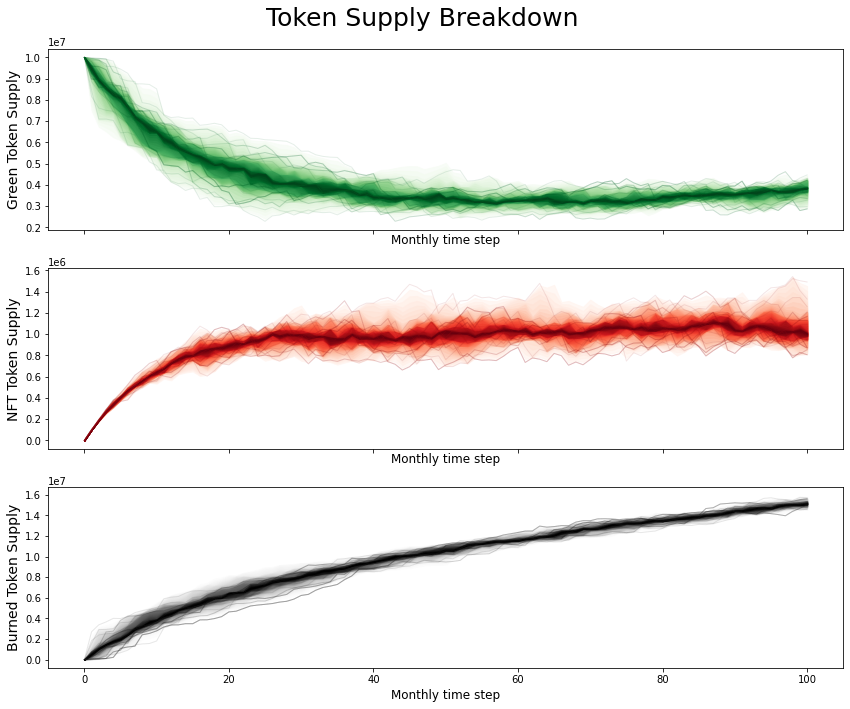

In [123]:
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt

N = 100
M = np.repeat(1,9).reshape((3, 3)); M[1,0] = 1
state=np.array([[1e7, 0.0, 0.0]])

dfDistrHist = markovChain(state, M, N)
green = dfDistrHist.Green.values.reshape(-1,1)
nft = dfDistrHist.NFT.values.reshape(-1,1)
burned = dfDistrHist.Burned.values.reshape(-1,1)
burned_minted_tot = dfDistrHist.Burned_Minted_Tot.values.reshape(-1,1)
green_minted_tot = dfDistrHist.Green_Minted_Tot.values.reshape(-1,1)
burned_minted = dfDistrHist.Burned_Minted.values.reshape(-1,1)
green_minted = dfDistrHist.Green_Minted.values.reshape(-1,1)

for k in range(1,25):
    dfDistrHist = markovChain(state, M, N)
    green = np.hstack((green, dfDistrHist.Green.values.reshape(-1,1)))
    nft = np.hstack((nft, dfDistrHist.NFT.values.reshape(-1,1)))
    burned = np.hstack((burned, dfDistrHist.Burned.values.reshape(-1,1)))
    burned_minted_tot = np.hstack((burned_minted_tot, dfDistrHist.Burned_Minted_Tot.values.reshape(-1,1)))
    green_minted_tot = np.hstack((green_minted_tot, dfDistrHist.Green_Minted_Tot.values.reshape(-1,1)))  
    burned_minted = np.hstack((burned_minted, dfDistrHist.Burned_Minted.values.reshape(-1,1)))
    green_minted = np.hstack((green_minted, dfDistrHist.Green_Minted.values.reshape(-1,1)))

fig, (green_ax, nft_ax, burned_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(12, 10))
fig.suptitle('Token Supply Breakdown', fontsize=25)
plot_gp_dist(green_ax, green.transpose(), np.array(range(0,len(green))), palette="Greens")
green_ax.set_xlabel("Monthly time step", fontsize=12)
green_ax.set_ylabel("Green Token Supply", fontsize=14)  
#green_ax.set_ylim((0,1.1e7))

plot_gp_dist(nft_ax, nft.transpose(), np.array(range(0,len(green))), palette="Reds")
nft_ax.set_xlabel("Monthly time step", fontsize=12)
nft_ax.set_ylabel("NFT Token Supply", fontsize=14)    

plot_gp_dist(burned_ax, burned.transpose(), np.array(range(0,len(green))), palette="Greys")
burned_ax.set_xlabel("Monthly time step", fontsize=12)
burned_ax.set_ylabel("Burned Token Supply", fontsize=14)
fig.savefig('token_supply_sims.png')
plt.tight_layout()

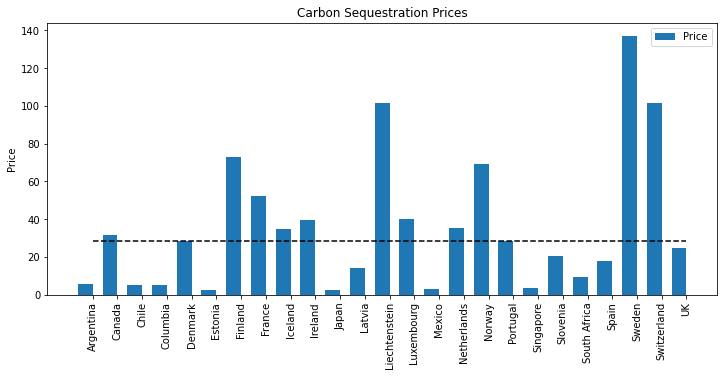

In [170]:
carbon_price = pd.read_csv('carbon_price.csv')
carbon_price = carbon_price[['Country','Price']]

labels = carbon_price['Country'].values
price = carbon_price['Price'].values

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
median_price = np.median(price)

fig = plt.subplots(figsize=(12, 5))
rects1 = plt.bar(x - width/2, price, width, label='Price')

plt.ylabel('Price')
plt.plot(x, np.repeat(median_price,len(x)), "k--")
plt.title('Carbon Sequestration Prices')
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.show()

https://github.com/openclimatedata/edgar-co2-emissions

['Power Industry','Other Industrial','Buildings','Transport','Other Sectos']

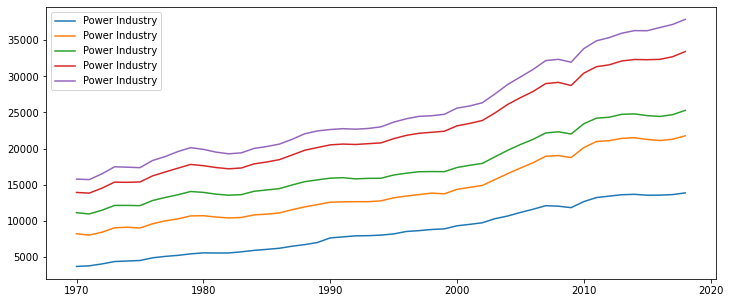

In [125]:
co2 = pd.read_csv('edgar-co2-emissions.csv')
co2_aggr = co2.groupby(['Sector', 'Year']).agg({'Emissions': ['sum']})

co2_aggr.reset_index(inplace=True)
co2_aggr.columns = ['Sector','Year', 'Emissions']

sectors = np.unique(co2_aggr['Sector'].values)
sectors = ['Power Industry','Other industrial combustion','Buildings','Transport','Other sectors']
#sectors = sectors[::-1]
yr = co2_aggr[['Year']].loc[co2_aggr['Sector'] == sectors[0]].values.flatten()
fig = plt.figure(figsize=(12, 5))
emissions_aggr = np.zeros(49)
emissions_df = pd.DataFrame({'Year':yr})
for k in range(len(sectors)):
    emissions = co2_aggr[['Emissions']].loc[co2_aggr['Sector'] == sectors[k]].values.flatten()
    emissions_aggr = emissions_aggr + emissions
    emissions_df.insert(k, sectors[k], emissions_aggr, True)
    plt.plot(yr, emissions_aggr, label=sector)
plt.legend() 

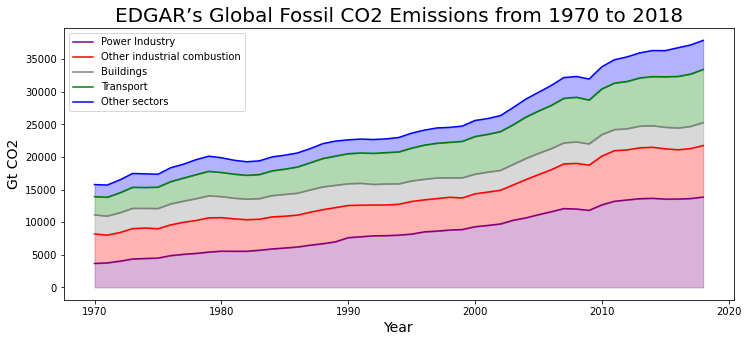

In [126]:
colors = ['purple','red','grey','green','blue']

fig = plt.figure(figsize=(12, 5))
yr = emissions_df['Year'].values
for k in range(len(sectors)):
    emissions = emissions_df[sectors[k]].values
    plt.plot(yr, emissions, label=sectors[k],color=colors[k])  
    bot_line = np.zeros(49) if k == 0 else emissions_df[sectors[k-1]].values
    plt.fill_between(yr, bot_line, emissions, alpha=0.3, color=colors[k])
plt.xlabel('Year', fontsize=14)
plt.ylabel('Gt CO2', fontsize=14)
plt.title("EDGAR’s Global Fossil CO2 Emissions from 1970 to 2018", fontsize=20)
plt.legend() 
fig.savefig('edgars_co2_emissions.png')

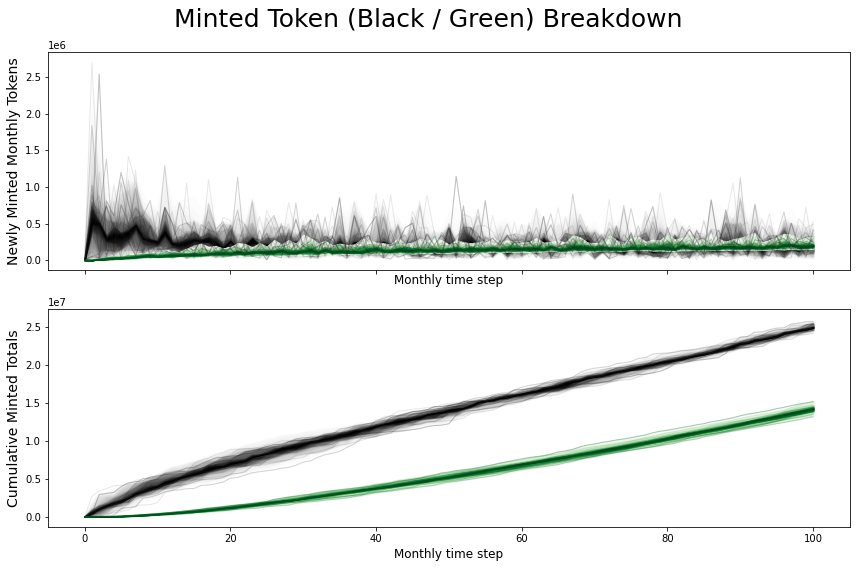

In [127]:
fig, (new_ax, tot_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 8))
fig.suptitle('Minted Token (Black / Green) Breakdown', fontsize=25)

plot_gp_dist(new_ax, burned_minted.transpose(), np.array(range(0,len(green))), palette="Greys")
plot_gp_dist(new_ax, green_minted.transpose(), np.array(range(0,len(green))), palette="Greens")
new_ax.set_xlabel("Monthly time step", fontsize=12)
new_ax.set_ylabel("Newly Minted Monthly Tokens", fontsize=14)  

plot_gp_dist(tot_ax, burned_minted_tot.transpose(), np.array(range(0,len(green))), palette="Greys")
plot_gp_dist(tot_ax, green_minted_tot.transpose(), np.array(range(0,len(green))), palette="Greens")
tot_ax.set_xlabel("Monthly time step", fontsize=12)
tot_ax.set_ylabel("Cumulative Minted Totals", fontsize=14)  
fig.savefig('burned_minted.png')
plt.tight_layout()

In [128]:
sequestered_carbon = getStats(burned_minted_tot[0,:])

for k in range(1, len(burned_minted_tot)):
    sequestered_carbon = np.vstack((sequestered_carbon, getStats(burned_minted_tot[k,:])))

sequestered_carbon = pd.DataFrame(sequestered_carbon, columns = ['mu', 'lwr', 'upr'])
delta_mu = np.diff(sequestered_carbon['mu'].values)
delta_mu = np.insert(delta_mu, 0, 0)
sequestered_carbon.insert(3, "delta_mu", delta_mu, True)

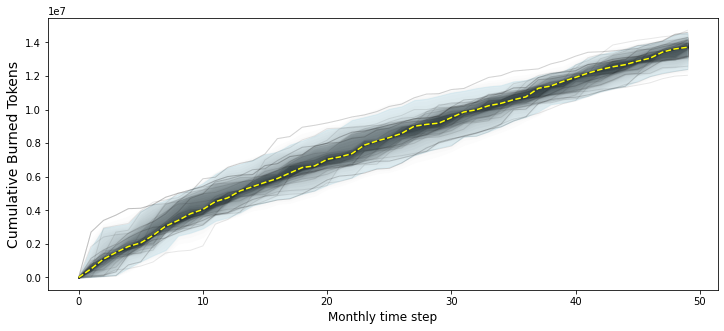

In [129]:
mu = sequestered_carbon['mu'].values
lwr = sequestered_carbon['lwr'].values
upr = sequestered_carbon['upr'].values
t = np.array(range(0,50))
fig = plt.figure(figsize=(12, 5))
tot_ax = fig.gca()
plot_gp_dist(tot_ax, burned_minted_tot[0:50].transpose(), t, palette="Greys")
tot_ax.plot(t, mu[0:50], color='yellow', linestyle='dashed', label="y_pred")
tot_ax.fill_between(t, lwr[0:50], upr[0:50], alpha=0.3, color='lightblue')
tot_ax.set_xlabel("Monthly time step", fontsize=12)
tot_ax.set_ylabel("Cumulative Burned Tokens", fontsize=14)  
fig.savefig('burned_tokens.png')

In [130]:
sequestered_carbon.iloc[::12, :]

,mu,lwr,upr,delta_mu
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
12,4.741065e+06,3.569991e+06,6.541410e+06,224839.897343
24,8.129362e+06,6.513420e+06,9.738362e+06,244275.858600
36,1.075881e+07,9.573795e+06,1.176023e+07,170879.842402
48,1.361781e+07,1.231980e+07,1.446784e+07,189080.080592
60,1.614915e+07,1.516960e+07,1.672179e+07,177015.729827
72,1.883084e+07,1.773294e+07,1.960516e+07,263717.162809
84,2.123727e+07,2.059571e+07,2.204264e+07,203308.508280
96,2.414218e+07,2.336372e+07,2.478557e+07,386249.076700


In [131]:
state=np.array([[1e7, 0.0, 0.0]])
state = state + np.array([[0, 10000, 0.0]])

In [132]:
dfDistrHist

,Green,NFT,Burned,Burned_Minted,Burned_Minted_Tot,Green_Minted,Green_Minted_Tot
0,1.000000e+07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
1,9.346118e+06,1.000000e+05,6.538819e+05,653881.891978,6.538819e+05,0.000000,0.000000e+00
2,9.236276e+06,1.852683e+05,7.784559e+05,131112.850870,7.849947e+05,15837.427869,1.583743e+04
3,8.505896e+06,2.712580e+05,1.522846e+06,752174.243598,1.537169e+06,16456.521340,3.229395e+04
4,8.424835e+06,3.440658e+05,1.631099e+06,123482.117068,1.660651e+06,30110.983188,6.240493e+04
...,...,...,...,...,...,...,...
96,3.682637e+06,1.106439e+06,1.481092e+07,544251.044038,2.419008e+07,145260.228036,1.339719e+07
97,3.847596e+06,1.143821e+06,1.470858e+07,45768.394851,2.423585e+07,199529.333917,1.359672e+07
98,3.803052e+06,1.055151e+06,1.494180e+07,380299.178278,2.461615e+07,205763.121173,1.380248e+07
99,3.815692e+06,1.083029e+06,1.500128e+07,208900.281647,2.482505e+07,173505.326754,1.397599e+07


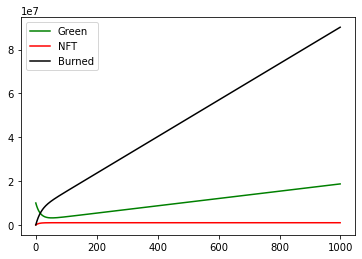

In [133]:
N = 1000
P = np.array([[0.95, 0, 0.05],
              [0.05, 0.9, 0.05],
              [0.01, 0, .99]])
state=np.array([[1e7, 0.0, 0.0]])
dfDistrHist = markovChain(state, M, N, P)

styles = ['g-','r-','k-','k--','g--']
#ax = dfDistrHist.iloc[:, [0,1,2,4,6]].head(N).plot(style = styles)   
ax = dfDistrHist.iloc[:, [0,1,2]].head(N).plot(style = styles)   

In [134]:
dfDistrHist.tail(10)

,Green,NFT,Burned,Burned_Minted,Burned_Minted_Tot,Green_Minted,Green_Minted_Tot
991,1.857222e+07,1000000.0,8.952778e+07,977777.777778,5.659773e+08,944444.444444,5.254995e+08
992,1.858889e+07,1000000.0,8.961111e+07,978611.111111,5.669559e+08,945277.777778,5.264448e+08
993,1.860556e+07,1000000.0,8.969444e+07,979444.444444,5.679354e+08,946111.111111,5.273909e+08
994,1.862222e+07,1000000.0,8.977778e+07,980277.777778,5.689156e+08,946944.444444,5.283379e+08
995,1.863889e+07,1000000.0,8.986111e+07,981111.111111,5.698968e+08,947777.777778,5.292856e+08
996,1.865556e+07,1000000.0,8.994444e+07,981944.444444,5.708787e+08,948611.111111,5.302343e+08
997,1.867222e+07,1000000.0,9.002778e+07,982777.777778,5.718615e+08,949444.444444,5.311837e+08
998,1.868889e+07,1000000.0,9.011111e+07,983611.111111,5.728451e+08,950277.777778,5.321340e+08
999,1.870556e+07,1000000.0,9.019444e+07,984444.444444,5.738295e+08,951111.111111,5.330851e+08
1000,1.872222e+07,1000000.0,9.027778e+07,985277.777778,5.748148e+08,951944.444444,5.340370e+08


In [135]:
supply = pd.DataFrame({'green':np.array([1e7]), 'red':np.array([0]), 'black':np.array([0])})

burned_black = np.array([0])
new_green = np.array([0]) 

for n in range(0,100):
    prev = supply.tail(1).values.flatten()
    green_i = prev[0] + 0.05*prev[1] + 0.01*prev[2] - 0.05*prev[0] - 0.05*prev[0]
    red_i = prev[1] + 0.05*prev[0] + 0*prev[2] - 0.05*prev[1] - 0.05*prev[1]
    black_i = prev[2] + 0.05*prev[0] + 0.05*prev[1] - 0*prev[2] - 0.01*prev[2]
    update = np.array([green_i,red_i,black_i])
    
    burned_black = np.append(burned_black, P[0,2]*prev[0] + P[1,2]*prev[1])
    new_green = np.append(new_green, P[1,0]*prev[1] + P[2,0]*prev[2])
    
    supply = supply.append(pd.DataFrame(update.reshape(1,-1), columns=list(supply)), ignore_index=True)

supply.insert(3, "burned_black", burned_black, True)
supply.insert(4, "tot_burned_black", np.cumsum(burned_black), True)
supply.insert(5, "new_green", new_green, True)
supply.insert(6, "tot_minted_green", np.cumsum(new_green), True)
supply.tail(10)

,green,red,black,burned_black,tot_burned_black,new_green,tot_minted_green
91,1.124395e+06,572156.381551,8.303448e+06,84922.961620,1.450287e+07,111676.197084,1.084300e+07
92,1.123598e+06,571160.508241,8.305241e+06,84827.583923,1.458770e+07,111642.302293,1.095464e+07
93,1.122849e+06,570224.360893,8.306927e+06,84737.928888,1.467244e+07,111610.439635,1.106625e+07
94,1.122144e+06,569344.359913,8.308511e+06,84653.653154,1.475709e+07,111580.487414,1.117783e+07
95,1.121482e+06,568517.139891,8.310001e+06,84574.433965,1.484167e+07,111552.331203,1.128938e+07
96,1.120860e+06,567739.536835,8.311401e+06,84499.967927,1.492617e+07,111525.863409,1.140091e+07
97,1.120275e+06,567008.576161,8.312717e+06,84429.969851,1.501060e+07,111500.982871,1.151241e+07
98,1.119725e+06,566321.461397,8.313954e+06,84364.171660,1.509496e+07,111477.594476,1.162389e+07
99,1.119208e+06,565675.563548,8.315116e+06,84302.321361,1.517926e+07,111455.608798,1.173534e+07
100,1.118722e+06,565068.411095,8.316209e+06,84244.182079,1.526351e+07,111434.941762,1.184678e+07


In [136]:
P = np.array([[0.9, 0.05, 0.05],
              [0.05, 0.9, 0.05],
              [0.01, 0, 0.99]])

A=np.append(np.transpose(P)-np.identity(3),[[1,1,1]],axis=0)
b=np.transpose(np.array([0,0,0,1]))
np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

array([0.11111111, 0.05555556, 0.83333333])

In [137]:
x = np.array([10,0,0])
y = np.array([2,0,0])

x*y.T

array([20,  0,  0])